In [1]:
import tensorflow           as tf
import matplotlib.pyplot    as plt
import pandas               as pd
import seaborn              as sns

from keras.applications         import ResNet50
from keras.models               import Sequential, load_model
from keras.layers               import Dense, GlobalAveragePooling2D
from keras.optimizers           import Adam
from keras.preprocessing.image  import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

from pathlib import Path

import shutil, splitfolders, os

Configurar TensorFlow para usar la GPU

In [2]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Elimina y recrea directorio split_imagenes, divide imágenes en carpetas de entrenamiento y validación

In [3]:
transformada = "cmor"

#Ruta al directoria split_imagenes
ruta_imagenes       = Path(f"../../../../imagenes/{transformada}")
ruta_split_imagenes = Path(f"../../../../split_imagenes/{transformada}")

#Si el directorio ya existe, eliminarlo junto con su contendio
if ruta_split_imagenes.exists():
    shutil.rmtree(ruta_split_imagenes)

#Crear el split de las imágenes de la transformada
splitfolders.ratio(input=ruta_imagenes, output=ruta_split_imagenes, ratio=(.8,.2))

Copying files: 4000 files [00:08, 448.37 files/s]


Se definen parámetros

In [4]:
# Definir rutas de las carpetas que contienen las imágenes
img_width, img_height   = 250, 250
input_shape             = (img_width, img_height, 3)

# Hiperparámetros
epochs      = 100
batch_size  = 16

Se crean los generadores de datos de imágenes

In [5]:
# Configurar el generador de datos de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagem = ImageDataGenerator(rescale=1./255)

# Cargar y dividir los datos en conjuntos de entrenamiento y prueba
generador_entrenamiento = train_datagen.flow_from_directory(
    ruta_split_imagenes/"train",
    target_size = (img_width, img_height),
    batch_size  = batch_size,
    class_mode  = 'binary',
    shuffle     = True
)

# Cargar imágenes de validación
generador_validacion = valid_datagem.flow_from_directory(
    ruta_split_imagenes/"val",
    target_size = (img_width, img_height),
    batch_size  = batch_size,
    class_mode  = 'binary',
    shuffle     = False
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Se carga el modelo preentrenado

In [6]:
# Cargar el modelo ResNet50 pre-entrenado sin la parte superior (include_top = False)
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar las capas de la ResNet50 pre-entrenada
for layer in ResNet50_model.layers:
    layer.trainable = False

Se agregan capas al final del modelo

In [7]:
# Construir el modelo
model = Sequential()
model.add(ResNet50_model)
model.add(GlobalAveragePooling2D()) # Reduce la dimensionalidad de los datos de salida
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Entrenamiento del modelo

In [8]:
#Se define un callback para guardar el mejor modelo basado en el val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath = "modelo_generado/mejor_modelo.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

# Entrenar el modelo
historia = model.fit(
    generador_entrenamiento,
    steps_per_epoch  = generador_entrenamiento.samples // batch_size,
    epochs           = epochs,
    validation_data  = generador_validacion,
    validation_steps = generador_validacion.samples // batch_size,
    callbacks        = [checkpoint_callback]
)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5291
Epoch 1: val_accuracy improved from -inf to 0.61500, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 75s 340ms/step - loss: 0.6945 - accuracy: 0.5291 - val_loss: 0.6806 - val_accuracy: 0.6150
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.5681
Epoch 2: val_accuracy improved from 0.61500 to 0.62250, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 17s 87ms/step - loss: 0.6809 - accuracy: 0.5681 - val_loss: 0.6721 - val_accuracy: 0.6225
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.6031
Epoch 3: val_accuracy improved from 0.62250 to 0.62500, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 18s 88ms/step - loss: 0.6705 - accuracy: 0.6031 - val_loss: 0.6649 - val_accuracy

Resumen del modelo

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


Se crean los directorios que almacenarán los resultados de las repeticiones

In [10]:
if not os.path.exists("repeticiones_experimento"):
    os.mkdir("repeticiones_experimento")
    os.mkdir("repeticiones_experimento/imagenes_curvas_roc_auc")
    os.mkdir("repeticiones_experimento/imagenes_entrenamientos/")
    os.mkdir("repeticiones_experimento/imagenes_matriz_confusion/")

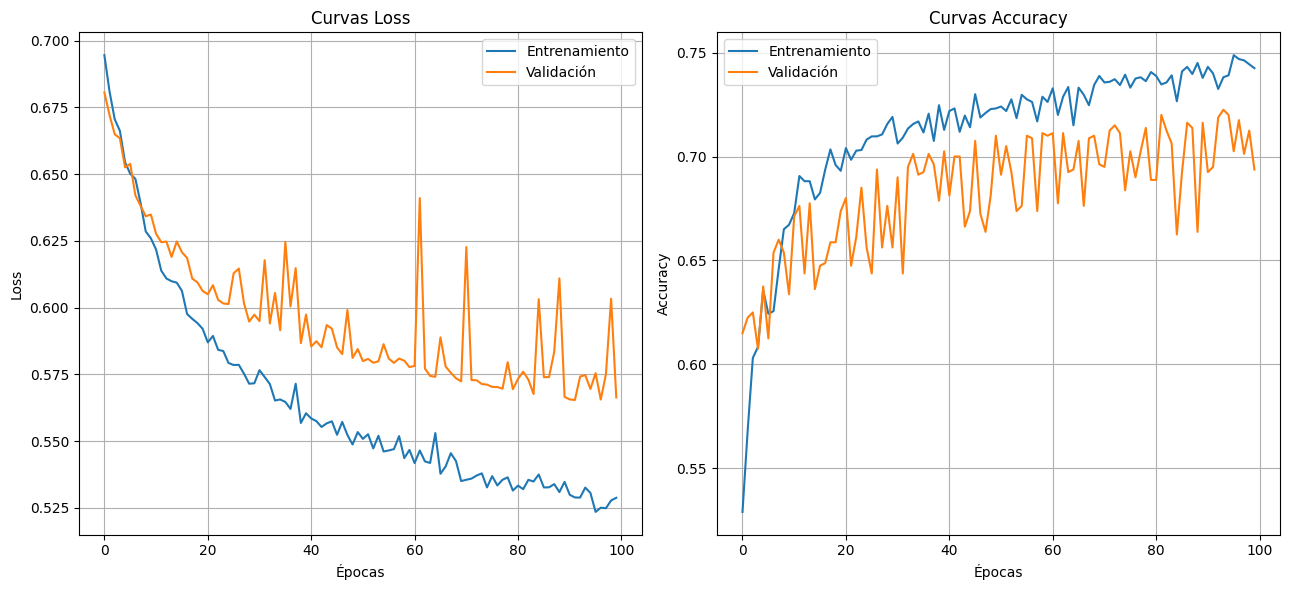

In [11]:
# Curvas de pérdida
plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.plot(historia.history['loss'], label='Entrenamiento')
plt.plot(historia.history['val_loss'], label='Validación')
plt.title('Curvas Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Curvas de precisión
plt.subplot(1, 2, 2)
plt.plot(historia.history['accuracy'], label='Entrenamiento')
plt.plot(historia.history['val_accuracy'], label='Validación')
plt.title('Curvas Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()

# Obteniendo el nombre de la imagen para la gráfica de entrenamiento
cant_img_train = len(os.listdir(path="repeticiones_experimento/imagenes_entrenamientos"))
name_img_train = f"imagen_entrenamiento_{cant_img_train+1}.png"
plt.savefig(f"repeticiones_experimento/imagenes_entrenamientos/{name_img_train}", dpi=600, bbox_inches='tight')

plt.show()

## **Parte 5:** Evaluación del modelo

Se evalua el mejor modelo guardado

In [12]:
mejor_modelo = load_model("modelo_generado/mejor_modelo.keras")
generador_validacion.reset()
resul_eva = mejor_modelo.evaluate(generador_validacion, verbose=False)

# Obtener los resultados de pérdida y accuracy
perdida = resul_eva[0]
accuracy = resul_eva[1]

print("Loss: {:.2f}".format(perdida))
print("Accuracy: {:.2%}".format(accuracy))

Loss: 0.57
Accuracy: 72.25%


Cálculo de diferentes métricas


Matriz de Confusión:


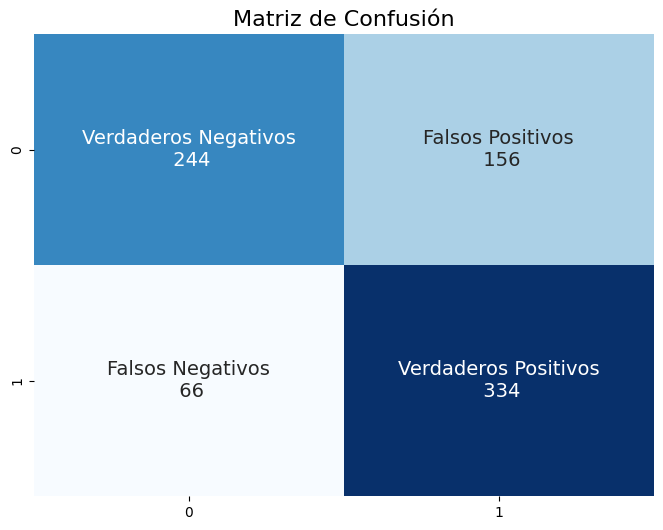

Accuracy:	72.25%
Sensitivity:	83.50%
Specificity:	61.00%
Precision:	68.16%
F1-score:	75.06%


In [13]:
# Obtener las predicciones del modelo
y_pred_prob = mejor_modelo.predict(generador_validacion, verbose=False)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.5).astype(int)

# Obtener las etiquetas verdaderas
y_test = generador_validacion.classes

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)

# Obteniendo el nombre de la imagen para la matriz de confusión
cant_img_matrix = len(os.listdir(path="repeticiones_experimento/imagenes_matriz_confusion"))
name_img_matrix = f"matriz_confusion_{cant_img_matrix+1}.png"
plt.savefig(f"repeticiones_experimento/imagenes_matriz_confusion/{name_img_matrix}", dpi=600, bbox_inches='tight')

plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))

Curva roc y auc

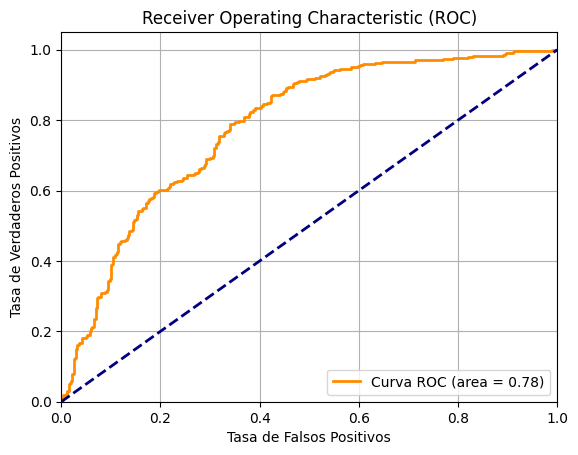

Área Bajo la Curva (AUC): 0.78


In [14]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualizar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()

# Obteniendo el nombre de la imagen para la curva ROC-AUC
cant_img_roc_auc = len(os.listdir(path="repeticiones_experimento/imagenes_curvas_roc_auc"))
name_img_roc_auc = f"roc_auc{cant_img_roc_auc+1}.png"
plt.savefig(f"repeticiones_experimento/imagenes_curvas_roc_auc/{name_img_roc_auc}", dpi=600, bbox_inches='tight')

plt.show()

# Imprimir el AUC
print(f"Área Bajo la Curva (AUC): {roc_auc:.2f}")

Se registran las métricas en cada iteración del experimento.

In [15]:
# Se crea un Dataframe con los nuevos resultados
new_data = pd.DataFrame({
    "Accuracy"      : [accuracy],
    "Sensitivity"   : [sensitivity],
    "Specificity"   : [specificity],
    "Precision"     : [precision],
    "F1"            : [f1],
    "Roc-Auc"       : [roc_auc]
})

# Especificar el nombre del archivo Excel
file_name = "repeticiones_experimento/metricas.xlsx"

#Verificar si el archivo ya existe
if os.path.exists(file_name):
    #Si el archivo existe, cargar los datos existentes
    existing_data = pd.read_excel(file_name, sheet_name="Métricas")
    #Concatenar los datos existentes con los nuevos datos
    df_metricas = pd.concat([existing_data, new_data], ignore_index=True)
else:
    #Si el archivo no existe, usar solo los nuevos datos
    df_metricas = new_data

#Guardar el Dataframe en el archivo Excel
df_metricas.to_excel(file_name, sheet_name="Métricas", index=False)